In [4]:
import requests
import warnings

import geopandas as gpd
import pandas as pd
import folium

import plotly.graph_objects as go

In [5]:
import plotly
plotly.__version__

'4.1.0'

# 흐름


1. 생활인구 데이터 불러오기

2. 특정 행정동의 집계구별 생활인구 시각화(folium 사용)

3. 특정 구의 행정동별 생활인구 시각화(plotly 사용) - 중요 

4. (버스정류장, 지하철역 위치정보 불러온 후) 접근성 데이터 시각화

5. 행정동별 하루 시간대별 생활인구 변화 양상

6. 행정동별 하루 특정 시간의 인구 비율(성별 + 연령대) top5 시각화

7. 하루 데이터로 (성별, 연령대, 시간) 행정동 생활인구 많은 top5 시각화

8. 행정동별 월간의 하루 평균 생활인구의 변화 양상

9. 생활 등급 지수화


## 생활인구 데이터 불러오기

<주의할 점>

- 생활인구 데이터의 행정동 코드 : 행안부 (10자리) - H_DNG_CD
- 집계구, 행정동 지형 데이터의 행정동 코드 : 통계청 (7자리) - adm_cd

## 19.08.07 생활인구 데이터

---
<컬럼 설명>

- TT : 시간대 (ex : 0 -> 0 ~ 1시)
- H_DNG_CD : 행정동 코드
- SMGU_CD : 집계구 코드
- SPOP : 총 생활인구 수
- (M or F)(숫자) : 성별 + 연령별 -> ex: M20 : 남자 (20~ 29세)


In [6]:
living_df = pd.read_csv("use_data/living_people_20190807.csv")
living_df['SMGU_CD'] = living_df['SMGU_CD'].map(str)
living_df['H_DNG_CD'] = living_df['H_DNG_CD'].map(str)

In [7]:
living_df.head()

TT    H_DNG_CD        SMGU_CD   SPOP  M00  M10  M20  M30  M40  M50  M60  \
0   0  1111051500  1101072010001  604.0   32   42   49   38   52   37   20   
1   0  1111051500  1101072010002  888.0   22   32   55   70   88   54   43   
2   0  1111051500  1101072010003   75.0    0    0    0    0    0    8    4   
3   0  1111051500  1101072010004  288.0   21   17   21   14   18   18   17   
4   0  1111051500  1101072010005  198.0    7   10   12   10   14   18    5   

   M70  F00  F10  F20  F30  F40  F50  F60  F70  
0   22   25   31   34   43   59   47   22   35  
1   27   15   43   64   70   84   67   55   88  
2    5    0    0    0    0    4    8    4   12  
3    8   13   14   20   20   18   15    7   31  
4    9    5    0    8   11   18   21   11   17

## 집계구별 경계 데이터

- geojson은 geopandas 활용해 load
- 경계 데이터의 행정동 코드는 ADM_CD(통계청)에서 제공하는 행정동 코드임을 주의

In [8]:
gibgyegu_geojson_df = gpd.read_file("use_data/서울시_집계구_2016.geojson")

In [9]:
# 좌표계 단위 확인
gibgyegu_geojson_df.crs

{'init': 'epsg:4326'}

In [10]:
gibgyegu_geojson_df.head()

OBJECTID ADM_DR_CD      TOT_OA_CD  SHAPE_LENG    SHAPE_AREA  \
0         1   1105053  1105053010001  331.678684   6928.712695   
1         2   1105053  1105053010003  614.966812  17541.366177   
2         3   1105053  1105053010018  426.615266   9555.028259   
3         4   1105053  1105053010005  465.147064  11037.532216   
4         5   1105053  1105053010004  616.801217  22056.499318   

                                            geometry  
0  (POLYGON ((127.0697402042 37.5453789883, 127.0...  
1  (POLYGON ((127.0727080668 37.5443298612, 127.0...  
2  (POLYGON ((127.0691888464 37.546894422, 127.06...  
3  (POLYGON ((127.0721669848 37.547225838, 127.07...  
4  (POLYGON ((127.0741273789 37.5472834654, 127.0...

In [8]:
gibgyegu_geojson_df.shape

(19445, 6)

In [9]:
# 생활인구 데이터 컬럼과 맞추기 위해 컬럼명 변경
gibgyegu_geojson_df.rename(columns={'TOT_OA_CD': 'SMGU_CD'}, inplace=True)
# 지도 시각화에 사용하지 않는 부분은 제거
del gibgyegu_geojson_df['OBJECTID']
del gibgyegu_geojson_df['SHAPE_LENG']
del gibgyegu_geojson_df['SHAPE_AREA']

In [10]:
gibgyegu_geojson_df.head()

ADM_DR_CD        SMGU_CD                                           geometry
0   1105053  1105053010001  (POLYGON ((127.0697402042 37.5453789883, 127.0...
1   1105053  1105053010003  (POLYGON ((127.0727080668 37.5443298612, 127.0...
2   1105053  1105053010018  (POLYGON ((127.0691888464 37.546894422, 127.06...
3   1105053  1105053010005  (POLYGON ((127.0721669848 37.547225838, 127.07...
4   1105053  1105053010004  (POLYGON ((127.0741273789 37.5472834654, 127.0...

## 집계구별 중심 데이터

- 중심점 데이터 : 대시보드가 웹 화면에 처음 나왔을 때, 혹은 callback으로 시각화되는 지도 위치 바뀔 때, default 위치로 사용하는 용도

In [11]:
jibgyegu_center = pd.read_csv('use_data/서울시_집계구_중심점_2016.csv')

In [12]:
jibgyegu_center.head()

X          Y    H_DNG_CD        SMGU_CD  SHAPE_LENG   SHAPE_AREA
0  127.069260  37.545268  1105053000  1105053010001   331.67868   6928.71270
1  127.071821  37.543413  1105053000  1105053010003   614.96681  17541.36618
2  127.068830  37.546950  1105053000  1105053010018   426.61527   9555.02826
3  127.071179  37.547064  1105053000  1105053010005   465.14706  11037.53222
4  127.073014  37.546913  1105053000  1105053010004   616.80122  22056.49932

In [13]:
jibgyegu_center.shape

(19445, 6)

## 행정동별 경계 데이터
- 경계 데이터의 행정동 코드는 ADM_CD(통계청)에서 제공하는 행정동 코드임을 주의

In [14]:
hdong_geojson = gpd.read_file('use_data/서울_행정동_경계_2017.geojson')

In [15]:
# 좌표계 단위 
hdong_geojson.crs

{'init': 'epsg:4326'}

In [16]:
hdong_geojson.head()

adm_cd         adm_nm                                           geometry
0  1101053  서울특별시 종로구 사직동  POLYGON ((126.9768888427482 37.57565077944879,...
1  1101054  서울특별시 종로구 삼청동  POLYGON ((126.982689386493 37.5950655194224, 1...
2  1101055  서울특별시 종로구 부암동  POLYGON ((126.9758511377569 37.59656422224408,...
3  1101056  서울특별시 종로구 평창동  POLYGON ((126.9750746678809 37.63138628651299,...
4  1101057  서울특별시 종로구 무악동  POLYGON ((126.960673532739 37.58079784202972, ...

## 행정동 중심점 데이터

- 중심점 데이터 : 대시보드가 웹 화면에 처음 나왔을 때, 혹은 callback으로 시각화되는 지도 위치 바뀔 때, default 위치로 사용하는 용도

In [17]:
hdong_center = pd.read_csv('use_data/서울시_행정동_중심점_2017.csv', encoding='utf-8')

In [18]:
hdong_center.head()

H_DNG_CD SIDO_NM SIGUNGU_NM DNG_NM           X          Y
0  1111051500   서울특별시        종로구  청운효자동  126.970418  37.584658
1  1111053000   서울특별시        종로구    사직동  126.970144  37.574108
2  1111054000   서울특별시        종로구    삼청동  126.981114  37.588013
3  1111055000   서울특별시        종로구    부암동  126.962557  37.596699
4  1111056000   서울특별시        종로구    평창동  126.969274  37.613965

In [19]:
hdong_center['H_DNG_CD'] = hdong_center['H_DNG_CD'].map(str)

## 행정동 코드 데이터

- 생활인구 데이터의 행정동코드(H_DNG_CD)와 경계 데이터의 행정동 코드(ADM_CD)를 매핑하는 용도의 테이블 

- H_DNG_CD : 행정안전부의 10자리 행정동 코드
- ADM_CD : 통계청의 7자리 행정동 코드

In [20]:
hdong_code = pd.read_csv('use_data/hdong_seoul_final_201804.csv')
hdong_code.fillna("", inplace=True)
hdong_code['H_DNG_CD'] = hdong_code['H_DNG_CD'].map(str)
hdong_code['ADM_CD'] = hdong_code['ADM_CD'].map(str)

In [21]:
hdong_code.head()

H_DNG_CD   ADM_CD SIDO_NM SIGUNGU_NM DNG_NM             JUSO
0  1100000000  1100000   서울특별시                            서울특별시  
1  1111000000  1101000   서울특별시        종로구              서울특별시 종로구 
2  1111051500  1101072   서울특별시        종로구  청운효자동  서울특별시 종로구 청운효자동
3  1111053000  1101053   서울특별시        종로구    사직동    서울특별시 종로구 사직동
4  1111054000  1101054   서울특별시        종로구    삼청동    서울특별시 종로구 삼청동

## 자치구 중심점 데이터

In [22]:
jachigu_center = pd.read_csv('use_data/서울시_자치구_중심점_2017.csv', encoding='utf-8')
jachigu_center.drop(['Unnamed: 0'], axis=1, inplace=True)

In [23]:
jachigu_center.head()

GU_CD SIDO_NM SIGUNGU_NM           X          Y
0  11110   서울특별시        종로구  126.977321  37.594917
1  11140   서울특별시         중구  126.995968  37.560144
2  11170   서울특별시        용산구  126.979907  37.531385
3  11200   서울특별시        성동구  127.041058  37.551030
4  11215   서울특별시        광진구  127.085744  37.546706

# 특정 행정동의 집계구별 생활인구 시각화(folium)

a) 사용 데이터

생활 인구 데이터, 행정동 코드 데이터, 집계구별 경계 데이터

b) input

행정동 이름, 시간대, 성별_나이 정보

c) 코드 진행 순서 

- 1) 생활인구 데이터 -> 특정 시간대로 필터링
- 2) 행정동 코드 데이터 사용해 input으로 받은 행정동의 행정동 코드 받아옴
- 3) total_df : 집계구별 경계 데이터와 생활 인구 데이터 merge(공통 컬럼 : SMGU_CD(집계구 코드))
- 4) total_df 중 input으로 받은 행정동 코드만 필터링(dong_gibgyegu_df)
- 5) dong_gibgyegu_df를 geojson으로 변환(dong_gibgyegu_json)
- 6) 특정 행정동의 중심점 좌표 받아오기(center)
- 7) dong_gibgyegu_json 파일 활용해 지도 시각화 (이 함수에서는 folium  library을 활용)


In [23]:
def make_map_gibgyegu(hdong : str, time: int, gender_age:str ='SPOP') -> folium.Map:
    """
    특정 행정동, 시간, 성+연령대별 구분 입력했을 때 집계구 단위의 생활 인구 지도 시각화

    :param hdong: 행정동 ( 주의) 종로1.2.3.4동 이런 경우 .으로 적어야 함)
    :param time: 시간 (0 ~ 23)
    :param gender_age: 성별, 나이대(파라미터 값 입력 안했을 때(SPOP) -> 성별, 나이대 총합)
        > input 형식
            - (M or F) + (00, 10, 20, 30, 40, 50, 60, 70)
            ex) M10 : 남자 10 ~ 19세, F30 : 여자 30 ~ 39세

    :return: 지도
    """
    # c-1) 생활인구 데이터 -> 특정 시간대로 필터링
    living_df_time = living_df[living_df['TT'] == time]
    # c-2) 행정동 코드 데이터 사용해 input으로 받은 행정동의 행정동 코드 받아옴
    h_code = hdong_code[hdong_code['DNG_NM'] == hdong]['H_DNG_CD'].iloc[0]

    # c-3) total_df : 집계구별 경계 데이터와 생활 인구 데이터 merge(공통 컬럼 : SMGU_CD(집계구 코드))
    total_df = pd.merge(left=gibgyegu_geojson_df, right=living_df_time, on='SMGU_CD')
    
    # c-4) total_df 중 input으로 받은 행정동 코드만 필터링(dong_gibgyegu_df)
    dong_gibgyegu_df = total_df[total_df['H_DNG_CD'] == h_code]

    # c-5) dong_gibgyegu_df를 geojson으로 변환(dong_gibgyegu_json)
    dong_gibgyegu_json = dong_gibgyegu_df.to_json()
    
    # c-6) 특정 행정동의 중심점 좌표 받아오기(center)
    center = hdong_center[hdong_center['H_DNG_CD'] == h_code]
    
    # c-7) dong_gibgyegu_json 파일 활용해 지도 시각화 (이 함수에서는 folium library을 활용)
    map_gibgyegu = folium.Map(location=[center['Y'], center['X']], zoom_start=15)

    map_gibgyegu.choropleth(
        geo_data=dong_gibgyegu_json,
        data=dong_gibgyegu_df,
        columns=['SMGU_CD', 'SPOP'],
        fill_color='OrRd',
        key_on='feature.properties.SMGU_CD'
    )
    return map_gibgyegu

In [24]:
map1 = make_map_gibgyegu(hdong="합정동", time=12)

C:\Users\ASUS\.conda\envs\dash_test\lib\site-packages\folium\folium.py:415: FutureWarning:

The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.



In [25]:
map1

# 특정 구의 행정동별 생활 인구 시각화(plotly)

## cf> plotly dash 이용할 때 geojson 파일에 추가해야 하는 코드



<br>

https://plot.ly/python/reference/ 에 들어가서 geojson 단어를 검색하면

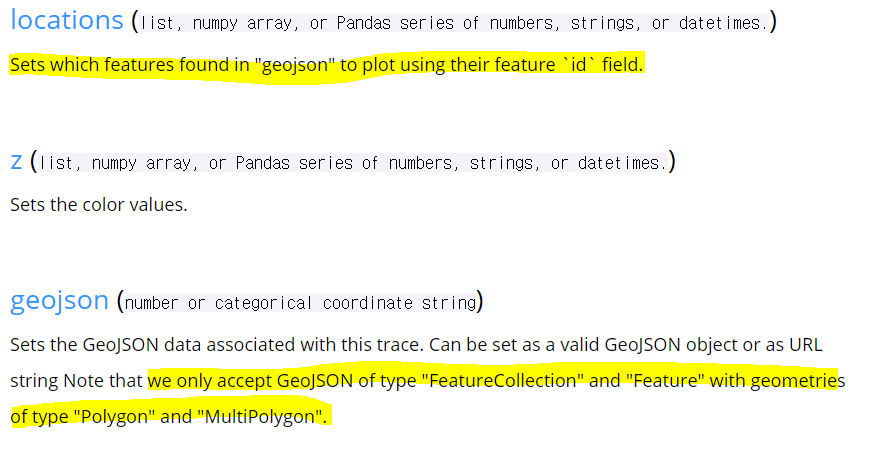

<br>

geojson 으로 plot할 때 json 에 id field가 있어야 함

현재 가지고 있는 데이터에는 id field가 없기 때문에, 수동으로 id field를 추가해줘야 함

In [26]:
# load json data
import json
with open('use_data/서울_행정동_경계_2017.geojson', encoding='utf-8') as json_file:
    hdong_geojson_temp = json.load(json_file)

In [28]:
hdong_geojson_temp

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'adm_cd': '1101053', 'adm_nm': '서울특별시 종로구 사직동'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[126.97688884274817, 37.575650779448786],
      [126.9770344988775, 37.569194530054546],
      [126.97597472821249, 37.569336299425764],
      [126.97537470991254, 37.56931556702156],
      [126.97433193562325, 37.56926180051753],
      [126.96904837001854, 37.56819441770831],
      [126.96854493603384, 37.56842767961275],
      [126.9666499598212, 37.56949165520657],
      [126.96628175024485, 37.5697007347987],
      [126.9660973270804, 37.5698565097237],
      [126.96572852922577, 37.570183936115114],
      [126.96592699822128, 37.5703188056862],
      [126.96601094018429, 37.57154839557748],
      [126.96365922052196, 37.57517466066036],
      [126.96308600434513, 37.57648592001553],
      [126.96284099051198, 37.5

In [29]:
# 행정동 개수 : 424개
len(hdong_geojson_temp['features'])

424

In [30]:
# 이 부분에 id key값이 있어야 함
# id key 값의 value는 'adm_cd'를 사용
hdong_geojson_temp['features'][0]

{'type': 'Feature',
 'properties': {'adm_cd': '1101053', 'adm_nm': '서울특별시 종로구 사직동'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[126.97688884274817, 37.575650779448786],
    [126.9770344988775, 37.569194530054546],
    [126.97597472821249, 37.569336299425764],
    [126.97537470991254, 37.56931556702156],
    [126.97433193562325, 37.56926180051753],
    [126.96904837001854, 37.56819441770831],
    [126.96854493603384, 37.56842767961275],
    [126.9666499598212, 37.56949165520657],
    [126.96628175024485, 37.5697007347987],
    [126.9660973270804, 37.5698565097237],
    [126.96572852922577, 37.570183936115114],
    [126.96592699822128, 37.5703188056862],
    [126.96601094018429, 37.57154839557748],
    [126.96365922052196, 37.57517466066036],
    [126.96308600434513, 37.57648592001553],
    [126.96284099051198, 37.576661586092726],
    [126.96281041047263, 37.57944880965677],
    [126.96742431584332, 37.57960153712449],
    [126.96742176302651, 37.579263521441646],
    [126.967

In [31]:
# id key 추가
for each in hdong_geojson_temp['features']:
    each['id'] = each['properties']['adm_cd']

In [32]:
# 마지막에 id 키 추가된 것을 확인
hdong_geojson_temp['features'][0]

{'type': 'Feature',
 'properties': {'adm_cd': '1101053', 'adm_nm': '서울특별시 종로구 사직동'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[126.97688884274817, 37.575650779448786],
    [126.9770344988775, 37.569194530054546],
    [126.97597472821249, 37.569336299425764],
    [126.97537470991254, 37.56931556702156],
    [126.97433193562325, 37.56926180051753],
    [126.96904837001854, 37.56819441770831],
    [126.96854493603384, 37.56842767961275],
    [126.9666499598212, 37.56949165520657],
    [126.96628175024485, 37.5697007347987],
    [126.9660973270804, 37.5698565097237],
    [126.96572852922577, 37.570183936115114],
    [126.96592699822128, 37.5703188056862],
    [126.96601094018429, 37.57154839557748],
    [126.96365922052196, 37.57517466066036],
    [126.96308600434513, 37.57648592001553],
    [126.96284099051198, 37.576661586092726],
    [126.96281041047263, 37.57944880965677],
    [126.96742431584332, 37.57960153712449],
    [126.96742176302651, 37.579263521441646],
    [126.967

In [33]:
mapbox_access_token = 'pk.eyJ1IjoibHVja3k4MDciLCJhIjoiY2p6NzB1NzJqMG8xdzNtbWtvOXhoMXg1MyJ9.IC7MS42-BMy9MAIyZyPavA'

In [34]:
living_people_df_hdong = living_df.groupby(by=['H_DNG_CD', 'TT']).sum().reset_index()
living_people_df_hdong['H_DNG_CD'] = living_people_df_hdong['H_DNG_CD'].map(str)

In [35]:
living_people_df_hdong_12h = living_people_df_hdong[living_people_df_hdong['TT'] == 12]

In [36]:
living_people_df_hdong_12h.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50   M60   M70  \
12   1111051500  12  19047.0  591  895  1560  1638  1726  1372   706   651   
36   1111053000  12  44494.0  645  746  2669  5180  5645  3456  1939  1418   
60   1111054000  12   9710.0  101  293   858  1148  1081   855   357   373   
84   1111055000  12  11566.0  306  503   844   660   762   812   534   509   
108  1111056000  12  15984.0  437  779   929   666   957  1077   774   796   

     F00   F10   F20   F30   F40   F50   F60   F70  
12   389   615  1356  1628  1735  1525   952  1095  
36   584   950  4391  5490  4263  2822  1910  1982  
60   114   201   722   933   802   701   559   536  
84   252   599   694   690   892   946   844  1308  
108  547  1010   800   839  1213  1450  1195  1683

In [37]:
# 행정동 코드 데이터
hdong_code.head()

H_DNG_CD   ADM_CD SIDO_NM SIGUNGU_NM DNG_NM             JUSO
0  1100000000  1100000   서울특별시                            서울특별시  
1  1111000000  1101000   서울특별시        종로구              서울특별시 종로구 
2  1111051500  1101072   서울특별시        종로구  청운효자동  서울특별시 종로구 청운효자동
3  1111053000  1101053   서울특별시        종로구    사직동    서울특별시 종로구 사직동
4  1111054000  1101054   서울특별시        종로구    삼청동    서울특별시 종로구 삼청동

In [38]:
final_df = pd.merge(left=living_people_df_hdong_12h, right=hdong_code, on='H_DNG_CD')

In [39]:
final_df.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50   M60  ...   F30  \
0  1111051500  12  19047.0  591  895  1560  1638  1726  1372   706  ...  1628   
1  1111053000  12  44494.0  645  746  2669  5180  5645  3456  1939  ...  5490   
2  1111054000  12   9710.0  101  293   858  1148  1081   855   357  ...   933   
3  1111055000  12  11566.0  306  503   844   660   762   812   534  ...   690   
4  1111056000  12  15984.0  437  779   929   666   957  1077   774  ...   839   

    F40   F50   F60   F70   ADM_CD  SIDO_NM  SIGUNGU_NM  DNG_NM  \
0  1735  1525   952  1095  1101072    서울특별시         종로구   청운효자동   
1  4263  2822  1910  1982  1101053    서울특별시         종로구     사직동   
2   802   701   559   536  1101054    서울특별시         종로구     삼청동   
3   892   946   844  1308  1101055    서울특별시         종로구     부암동   
4  1213  1450  1195  1683  1101056    서울특별시         종로구     평창동   

              JUSO  
0  서울특별시 종로구 청운효자동  
1    서울특별시 종로구 사직동  
2    서울특별시 종로구 삼청동  
3    서울특별시 종로구 부암동  
4    서울특별시 종로구 평창동  

[5 rows x 24 columns]

In [40]:
temp_df = final_df[final_df['SIGUNGU_NM'] == '종로구']

In [41]:
temp_df.head(3)

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50   M60  ...   F30  \
0  1111051500  12  19047.0  591  895  1560  1638  1726  1372   706  ...  1628   
1  1111053000  12  44494.0  645  746  2669  5180  5645  3456  1939  ...  5490   
2  1111054000  12   9710.0  101  293   858  1148  1081   855   357  ...   933   

    F40   F50   F60   F70   ADM_CD  SIDO_NM  SIGUNGU_NM  DNG_NM  \
0  1735  1525   952  1095  1101072    서울특별시         종로구   청운효자동   
1  4263  2822  1910  1982  1101053    서울특별시         종로구     사직동   
2   802   701   559   536  1101054    서울특별시         종로구     삼청동   

              JUSO  
0  서울특별시 종로구 청운효자동  
1    서울특별시 종로구 사직동  
2    서울특별시 종로구 삼청동  

[3 rows x 24 columns]

In [42]:
fig = go.Figure(data=go.Choroplethmapbox(
    locations = temp_df['ADM_CD'],
    z = temp_df['SPOP'],
    geojson = hdong_geojson_temp,
    colorscale='YlOrRd',
    marker = {"opacity" : 0.5},
    text = temp_df['DNG_NM']
))
fig.update_layout(mapbox_style="open-street-map",
                  mapbox_zoom=9, mapbox_center = {"lat": 37.541, "lon": 126.986})

In [45]:
# html 파일로 저장
plotly.offline.plot(fig, image_filename='sample/종로구_plotly.html')

'temp-plot.html'

## (버스정류장, 지하철역 위치정보 불러온 후) 접근성 데이터 시각화

In [73]:
# location_analysis -> modules -> geo.py에 있는 함수
# input으로 받은 위,경도 좌표를 기준으로 500m 내의 버스정류장, 지하철역의 위치 계산할 때 필요  

import haversine

def get_lat_and_lng_kakao(addr: str, key = '2664fcfab847446eab13d73ebde11089') -> (str, str):
    """
    주소 입력시 위, 경도 반환
    :param addr: 도로명주소 or 지번
    :param key: kakao rest-api key
    :return: 위도, 경도
    """
    api_host = 'https://dapi.kakao.com'
    headers = {"Authorization": "KakaoAK {}".format(key)}
    wantInfo = 'query={}'.format(addr)
    path = '/v2/local/search/address.json?{}'.format(wantInfo)
    url = api_host + path
    json_info = json.loads(requests.get(url, headers=headers).text)

    lat, lng = json_info['documents'][0]['road_address']['y'], json_info['documents'][0]['road_address']['x']

    return lat, lng

def calculate_distance(loc1 : (float, float), loc2 : (float , float)) -> float:
    """
    두 지점 사이의 거리를 구함(단위 : km) -> 500m 기준으로 True, False 분류
    :param loc1: 지점 1의 위, 경도 좌표
    :param loc2: 지점 2의 위, 경도 좌표
    :return: 두 지점 사이의 거리
    """
    distance = haversine.haversine(loc1, loc2)

    return distance

In [76]:
# location_analysis -> analysis and visualization -> Part2_Start Doctor Analysis -> 1. accessibility_to_bus_and_subway_station.py
def check_accesibility(addr: str, bus_df, subway_df) -> (dict, dict):
    """
    파라미터로 받은 주소 기준 반경 500m 내의 지하철역 + 버스정류장 이름, 역, 정류장과의 평균 거리를 반환

    :param addr: 지번, 혹은 도로명 주소
    :param bus_df: 버스정류장 dataframe
    :param subway_df: 지하철 dataframe

    :returns: bus_info (반경 500m 내 버스 정류장의 위치와, 정류장들까지의 평균 거리)
              sub_info (반경 500m 내 지하철역의 위치와, 정류장들까지의 평균 거리)
    """

    # 파라미터로 받은 주소 -> 위, 경도 좌표로 변환
    hos_coord = get_lat_and_lng_kakao(addr)
    hos_coord = tuple(map(float, hos_coord))

    # 버스 정류장
    bus_stations = []
    average_bus_distance = 0

    for (name, lat, lng) in zip(bus_df['정류소명'], bus_df['Y좌표'], bus_df['X좌표']):
        bus_station_position = (lat, lng)
        dist = calculate_distance(hos_coord, bus_station_position)

        if dist <= 0.5:
            bus_stations.append({"name": name, "location": bus_station_position, 'distance': int(dist * 1000)})
            average_bus_distance += dist

    average_bus_distance /= len(bus_stations)

    ### 지하철 역
    sub_stations = []
    average_subway_distance = 0

    for (name, lat, lng) in zip(subway_df["SUB_STA_NM"], subway_df['latitude'], subway_df['longitude']):
        sub_station_position = (lat, lng)
        dist = calculate_distance(hos_coord, sub_station_position)

        if dist <= 0.5:
            sub_stations.append({"name": name, "location": sub_station_position, 'distance': int(dist * 1000)})
            average_subway_distance += dist

    average_subway_distance /= len(sub_stations)

    bus_info = {"stations": bus_stations, "avg_dist": int(average_bus_distance * 1000)}
    sub_info = {"stations": sub_stations, "avg_dist": int(average_subway_distance * 1000)}

    return bus_info, sub_info

In [74]:
# 테스트 주소
test_addr = "서울 서대문구 신촌로 83"

In [77]:
test_location =  tuple(map(float, get_lat_and_lng_kakao(test_addr)))
test_location

(37.556081435548286, 126.93584374615689)

In [59]:
# 버스정류장 위치 정보
bus_df = pd.read_excel("use_data/part2)1-(2)버스정류소현황_서울.xlsx")
# 지하철역 위치 정보
subway_df = pd.read_excel("use_data/part2)1-(1)지하철역현황.xlsx")

In [60]:
bus_df.head()

정류소번호         정류소명         X좌표        Y좌표             법정동  \
0   1001      종로2가사거리  126.987750  37.569765  서울특별시 종로구 종로2가   
1   1002  창경궁.서울대학교병원  126.996566  37.579183   서울특별시 종로구 연건동   
2   1003    명륜3가.성대입구  126.998340  37.582671  서울특별시 종로구 명륜4가   
3   1004     종로2가.삼일교  126.987613  37.568579   서울특별시 종로구 관철동   
4   1005       혜화동로터리  127.001744  37.586243   서울특별시 종로구 혜화동   

                     행정동  
0  서울특별시 종로구 종로1.2.3.4가동  
1  서울특별시 종로구 종로1.2.3.4가동  
2          서울특별시 종로구 혜화동  
3  서울특별시 종로구 종로1.2.3.4가동  
4          서울특별시 종로구 혜화동

In [61]:
subway_df.head()

SUB_STA_NM   latitude   longitude
0        서울역  37.554648  126.972559
1         시청  37.564718  126.977108
2         종각  37.570161  126.982923
3       종로3가  37.571607  126.991806
4       종로5가  37.570926  127.001849

In [82]:
# 반경 500m 내 버스정류장, 지하철역 위치 정보
bus_info, sub_info = check_accesibility(test_addr, bus_df, subway_df)

In [83]:
bus_info

{'stations': [{'name': '연세대앞',
   'location': (37.5599353521, 126.9357001425),
   'distance': 428},
  {'name': '연세대앞',
   'location': (37.5601569117, 126.9354996016),
   'distance': 454},
  {'name': '세브란스병원앞',
   'location': (37.5599674551, 126.9384506818),
   'distance': 489},
  {'name': '신촌오거리.현대백화점',
   'location': (37.5553966479, 126.9358930618),
   'distance': 76},
  {'name': '신촌오거리.현대백화점',
   'location': (37.5559833987, 126.9345037666),
   'distance': 118},
  {'name': '신촌오거리.2호선신촌역',
   'location': (37.5560656888, 126.9401437605),
   'distance': 379},
  {'name': '신촌오거리.2호선신촌역',
   'location': (37.555788458, 126.9389815648),
   'distance': 278},
  {'name': '연세대학교앞',
   'location': (37.5597025524, 126.9351196694),
   'distance': 407},
  {'name': '연대앞',
   'location': (37.5603324543, 126.9351881706),
   'distance': 476},
  {'name': '세브란스병원',
   'location': (37.5598680153, 126.9378406593),
   'distance': 456},
  {'name': '신촌역2호선',
   'location': (37.5562422457, 126.9400304329),
   'd

In [84]:
sub_info

{'stations': [{'name': '신촌',
   'location': (37.555134, 126.936893),
   'distance': 140},
  {'name': '서강대', 'location': (37.551881, 126.935711), 'distance': 467}],
 'avg_dist': 303}

### plotly scattermap 지도 시각화

In [106]:
# plotly scattermap
fig1 = go.Figure()

# input으로 받은 위치
fig1.add_trace(go.Scattermapbox(
    lat = [test_location[0]],
    lon = [test_location[1]],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=20,
        color='red'
    ),
    text = "input으로 받은 위치", # 점에 mouse 갖다 댔을 때 나오는 text
    name = "input 위치" # legend 이름
))


# 버스 정류장
bus_lat = [each['location'][0] for each in bus_info['stations']]
bus_lon = [each['location'][1] for each in bus_info['stations']]

fig1.add_trace(go.Scattermapbox(
    lat = bus_lat,
    lon = bus_lon,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=12,
        color='blue'
    ),
    name = "버스 정류장"
))

# 지하철역
sub_lat = [each['location'][0] for each in sub_info['stations']]
sub_lon = [each['location'][1] for each in sub_info['stations']]

fig1.add_trace(go.Scattermapbox(
    lat = sub_lat,
    lon = sub_lon,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=12,
        color='green'
    ),
    name = "지하철역"
))

fig1.update_layout(mapbox_style="open-street-map",
                  mapbox_zoom=14, mapbox_center = {"lat": test_location[0], "lon": test_location[1]},
                  showlegend=True)

# 행정동별 하루 시간대별 생활인구 변화 양상

In [30]:
living_df_hdong = living_df.groupby(by=['H_DNG_CD', 'TT']).sum().reset_index()

In [49]:
hdong_df = living_df_hdong[living_df_hdong['H_DNG_CD'] == '1111051500']

In [32]:
hdong_df.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50  M60  M70  F00  \
0  1111051500   0  15862.0  511  816  1188  1079  1334   968  622  753  488   
1  1111051500   1  15887.0  511  815  1222  1096  1318   978  611  764  491   
2  1111051500   2  15965.0  511  817  1233  1103  1327  1006  612  770  489   
3  1111051500   3  16009.0  513  823  1247  1116  1333   993  610  781  479   
4  1111051500   4  16092.0  531  835  1254  1123  1313  1003  600  785  481   

   F10  F20   F30   F40   F50  F60   F70  
0  704  943  1239  1566  1209  878  1130  
1  702  945  1217  1577  1214  878  1116  
2  703  943  1220  1572  1207  883  1122  
3  698  945  1234  1570  1215  880  1120  
4  698  937  1249  1582  1226  886  1147

In [50]:
living_df_hdong['GU_CD'] = living_df_hdong['H_DNG_CD'].map(lambda h_code: h_code[:5])
living_df_hdong.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50  M60  M70  F00  \
0  1111051500   0  15862.0  511  816  1188  1079  1334   968  622  753  488   
1  1111051500   1  15887.0  511  815  1222  1096  1318   978  611  764  491   
2  1111051500   2  15965.0  511  817  1233  1103  1327  1006  612  770  489   
3  1111051500   3  16009.0  513  823  1247  1116  1333   993  610  781  479   
4  1111051500   4  16092.0  531  835  1254  1123  1313  1003  600  785  481   

   F10  F20   F30   F40   F50  F60   F70  GU_CD  
0  704  943  1239  1566  1209  878  1130  11110  
1  702  945  1217  1577  1214  878  1116  11110  
2  703  943  1220  1572  1207  883  1122  11110  
3  698  945  1234  1570  1215  880  1120  11110  
4  698  937  1249  1582  1226  886  1147  11110

In [51]:
living_df_hdong['GU_CD'].unique()

array(['11110', '11140', '11170', '11200', '11215', '11230', '11260',
       '11290', '11305', '11320', '11350', '11380', '11410', '11440',
       '11470', '11500', '11530', '11545', '11560', '11590', '11620',
       '11650', '11680', '11710', '11740'], dtype=object)

In [33]:
hdong_df.shape

(24, 19)

In [44]:
living_df_temp = living_df[living_df['H_DNG_CD'] == '1111051500']
living_df_temp.head()

TT    H_DNG_CD        SMGU_CD   SPOP  M00  M10  M20  M30  M40  M50  M60  \
0   0  1111051500  1101072010001  604.0   32   42   49   38   52   37   20   
1   0  1111051500  1101072010002  888.0   22   32   55   70   88   54   43   
2   0  1111051500  1101072010003   75.0    0    0    0    0    0    8    4   
3   0  1111051500  1101072010004  288.0   21   17   21   14   18   18   17   
4   0  1111051500  1101072010005  198.0    7   10   12   10   14   18    5   

   M70  F00  F10  F20  F30  F40  F50  F60  F70  
0   22   25   31   34   43   59   47   22   35  
1   27   15   43   64   70   84   67   55   88  
2    5    0    0    0    0    4    8    4   12  
3    8   13   14   20   20   18   15    7   31  
4    9    5    0    8   11   18   21   11   17

In [45]:
# 집계구 개수
gibgyegu_num = len(living_df_temp['SMGU_CD'].unique())
gibgyegu_num

26

In [52]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=hdong_df['TT'],
    y=hdong_df['SPOP'],
    name="행정동",
    #line_color='#FA5858',
))

fig.add_trace(go.Scatter(
    
))


fig.update_layout(
    xaxis = {'title': '시간'},
    yaxis = {'title': '생활인구 수'},
    title = {'text' : "행정동 하루 시간대별 생활인구 수 변화",
             'x' : 0.5,}
)

# 행정동별 하루 특정 시간의 인구 비율(성별 + 연령대) top5 시각화 

In [6]:
living_df = pd.read_csv("use_data/living_people_20190807.csv")
living_df['SMGU_CD'] = living_df['SMGU_CD'].map(str)
living_df['H_DNG_CD'] = living_df['H_DNG_CD'].map(str)
living_df_hdong = living_df.groupby(by=['H_DNG_CD', 'TT']).sum().reset_index()

In [16]:
living_df_hdong.head(24)

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50  M60  M70  F00  \
0   1111051500   0  15862.0  511  816  1188  1079  1334   968  622  753  488   
1   1111051500   1  15887.0  511  815  1222  1096  1318   978  611  764  491   
2   1111051500   2  15965.0  511  817  1233  1103  1327  1006  612  770  489   
3   1111051500   3  16009.0  513  823  1247  1116  1333   993  610  781  479   
4   1111051500   4  16092.0  531  835  1254  1123  1313  1003  600  785  481   
5   1111051500   5  16092.0  521  837  1257  1136  1345  1040  589  736  480   
6   1111051500   6  16688.0  537  865  1280  1260  1457  1122  664  726  481   
7   1111051500   7  17173.0  511  823  1484  1463  1558  1171  650  737  471   
8   1111051500   8  17982.0  488  841  1618  1672  1628  1188  670  714  490   
9   1111051500   9  18373.0  526  878  1630  1659  1697  1242  707  757  477   
10  1111051500  10  18607.0  541  900  1658  1608  1662  1260  723  735  531   
11  1111051500  11  18704.0  532  882  1600  1648  1617  1322  678  644  508   
12  1111051500  12  19047.0  591  895  1560  1638  1726  1372  706  651  389   
13  1111051500  13  18950.0  656  891  1542  1598  1713  1296  660  654  423   
14  1111051500  14  18585.0  597  851  1604  1602  1710  1293  599  716  412   
15  1111051500  15  18445.0  492  761  1568  1635  1767  1241  602  718  441   
16  1111051500  16  18082.0  526  760  1638  1601  1628  1231  577  777  384   
17  1111051500  17  17781.0  495  724  1500  1539  1698  1152  533  774  327   
18  1111051500  18  16530.0  478  665  1312  1356  1395  1035  565  780  308   
19  1111051500  19  16524.0  474  644  1323  1260  1499  1036  580  749  309   
20  1111051500  20  16320.0  441  627  1209  1233  1421  1063  595  757  351   
21  1111051500  21  15857.0  457  647  1207  1160  1453   997  585  753  389   
22  1111051500  22  15598.0  460  685  1226  1122  1406   961  582  756  386   
23  1111051500  23  15973.0  527  795  1206  1060  1438   945  606  728  420   

    F10   F20   F30   F40   F50   F60   F70  
0   704   943  1239  1566  1209   878  1130  
1   702   945  1217  1577  1214   878  1116  
2   703   943  1220  1572  1207   883  1122  
3   698   945  1234  1570  1215   880  1120  
4   698   937  1249  1582  1226   886  1147  
5   704   942  1244  1586  1232   878  1121  
6   685   946  1265  1609  1301   918  1122  
7   679   966  1287  1558  1294   927  1102  
8   632  1069  1478  1512  1346   998  1132  
9   629  1161  1527  1512  1398   982  1049  
10  719  1220  1506  1582  1429   913  1106  
11  645  1325  1596  1588  1461   967  1108  
12  615  1356  1628  1735  1525   952  1095  
13  613  1392  1543  1753  1524  1000  1089  
14  631  1377  1574  1607  1442   935  1001  
15  608  1346  1624  1648  1419   906   973  
16  508  1367  1517  1574  1356   872  1058  
17  471  1354  1532  1607  1395   851  1137  
18  463  1174  1399  1601  1310   902  1133  
19  454  1131  1406  1631  1337   928  1172  
20  531  1043  1374  1604  1305   967  1206  
21  560   917  1276  1606  1213   918  1140  
22  572   929  1222  1552  1191   912  1091  
23  680   929  1229  1646  1208   944  1176

In [14]:
living_df_hdong.groupby(by=['H_DNG_CD']).mean().reset_index()


H_DNG_CD    TT          SPOP          M00          M10          M20  \
0    1111051500  11.5  17130.250000   517.791667   794.875000  1398.583333   
1    1111053000  11.5  29605.500000   500.375000   563.583333  1887.166667   
2    1111054000  11.5   6952.791667    89.041667   335.708333   736.250000   
3    1111055000  11.5  12386.625000   313.666667   557.416667   820.250000   
4    1111056000  11.5  16988.833333   439.583333   809.333333   963.583333   
..          ...   ...           ...          ...          ...          ...   
419  1174065000  11.5  28248.875000  1175.291667   861.291667  1644.625000   
420  1174066000  11.5  30779.750000   991.291667  1558.833333  1981.541667   
421  1174068500  11.5  53750.875000  1664.125000  2038.541667  2972.625000   
422  1174069000  11.5   7066.333333   238.041667   430.083333   299.375000   
423  1174070000  11.5  29106.875000  1081.458333  1274.833333  1518.041667   

             M30          M40          M50          M60          M70  \
0    1365.291667  1518.458333  1121.458333   621.916667   738.125000   
1    3197.583333  3538.916667  2366.708333  1284.791667  1086.291667   
2     740.791667   739.041667   538.291667   278.375000   291.750000   
3     686.583333   879.208333   923.083333   603.541667   674.166667   
4     747.916667  1025.125000  1241.458333   912.916667   934.916667   
..           ...          ...          ...          ...          ...   
419  2193.916667  2018.125000  1917.875000  1406.208333  1413.875000   
420  2276.625000  2410.083333  2183.333333  1613.000000  1347.625000   
421  3869.291667  3840.875000  3866.083333  3306.875000  2602.750000   
422   322.833333   440.708333   402.041667   308.166667   324.291667   
423  1832.583333  1808.666667  1799.041667  1632.500000  2135.625000   

             F00          F10          F20          F30          F40  \
0     433.541667   621.000000  1110.708333  1391.083333  1599.083333   
1     459.208333   708.500000  2765.416667  3312.333333  2750.208333   
2      90.708333   163.166667   481.458333   590.666667   526.250000   
3     272.416667   559.416667   674.250000   767.291667  1014.333333   
4     565.291667   849.875000   862.625000   908.333333  1302.041667   
..           ...          ...          ...          ...          ...   
419   882.875000   884.666667  2123.500000  2305.166667  2023.875000   
420   856.458333  1094.250000  2245.625000  2401.875000  2414.250000   
421  1835.666667  1854.916667  3517.791667  3878.541667  4008.125000   
422   193.208333   257.500000   281.416667   345.291667   474.708333   
423   882.333333  1084.375000  1743.250000  1922.208333  2165.958333   

             F50          F60          F70  
0    1323.208333   919.791667  1110.250000  
1    1979.500000  1343.833333  1508.625000  
2     499.875000   376.416667   399.500000  
3    1058.083333   859.000000  1349.041667  
4    1605.291667  1232.416667  1799.666667  
..           ...          ...          ...  
419  2401.000000  2164.458333  1933.958333  
420  2657.458333  2023.833333  1947.416667  
421  4994.416667  4124.833333  3670.000000  
422   470.708333   343.875000   554.083333  
423  2444.958333  2189.416667  2460.958333  

[424 rows x 19 columns]

In [55]:
fig

# 하루 데이터로 (성별, 연령대, 시간) 행정동 생활인구 많은 top5 시각화

In [63]:
living_df = pd.read_csv("use_data/living_people_20190807.csv")
living_df['SMGU_CD'] = living_df['SMGU_CD'].map(str)
living_df['H_DNG_CD'] = living_df['H_DNG_CD'].map(str)
living_df_hdong = living_df.groupby(by=['H_DNG_CD', 'TT']).sum().reset_index()

In [80]:
hdong_code = pd.read_csv('use_data/hdong_seoul_final_201804.csv')
hdong_code.fillna("", inplace=True)
hdong_code['H_DNG_CD'] = hdong_code['H_DNG_CD'].map(str)
hdong_code['ADM_CD'] = hdong_code['ADM_CD'].map(str)

In [81]:
hdong_code.head()

H_DNG_CD   ADM_CD SIDO_NM SIGUNGU_NM DNG_NM             JUSO
0  1100000000  1100000   서울특별시                            서울특별시  
1  1111000000  1101000   서울특별시        종로구              서울특별시 종로구 
2  1111051500  1101072   서울특별시        종로구  청운효자동  서울특별시 종로구 청운효자동
3  1111053000  1101053   서울특별시        종로구    사직동    서울특별시 종로구 사직동
4  1111054000  1101054   서울특별시        종로구    삼청동    서울특별시 종로구 삼청동

In [83]:
juso = hdong_code[hdong_code['H_DNG_CD'] == '1111051500']['JUSO']
juso

2    서울특별시 종로구 청운효자동
Name: JUSO, dtype: object

In [64]:
living_df_hdong.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50  M60  M70  F00  \
0  1111051500   0  15862.0  511  816  1188  1079  1334   968  622  753  488   
1  1111051500   1  15887.0  511  815  1222  1096  1318   978  611  764  491   
2  1111051500   2  15965.0  511  817  1233  1103  1327  1006  612  770  489   
3  1111051500   3  16009.0  513  823  1247  1116  1333   993  610  781  479   
4  1111051500   4  16092.0  531  835  1254  1123  1313  1003  600  785  481   

   F10  F20   F30   F40   F50  F60   F70  
0  704  943  1239  1566  1209  878  1130  
1  702  945  1217  1577  1214  878  1116  
2  703  943  1220  1572  1207  883  1122  
3  698  945  1234  1570  1215  880  1120  
4  698  937  1249  1582  1226  886  1147

In [132]:
temp = living_df_hdong[(living_df_hdong['TT'] == 12)]

In [133]:
temp.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50   M60   M70  \
12   1111051500  12  19047.0  591  895  1560  1638  1726  1372   706   651   
36   1111053000  12  44494.0  645  746  2669  5180  5645  3456  1939  1418   
60   1111054000  12   9710.0  101  293   858  1148  1081   855   357   373   
84   1111055000  12  11566.0  306  503   844   660   762   812   534   509   
108  1111056000  12  15984.0  437  779   929   666   957  1077   774   796   

     F00   F10   F20   F30   F40   F50   F60   F70  
12   389   615  1356  1628  1735  1525   952  1095  
36   584   950  4391  5490  4263  2822  1910  1982  
60   114   201   722   933   802   701   559   536  
84   252   599   694   690   892   946   844  1308  
108  547  1010   800   839  1213  1450  1195  1683

In [134]:
temp = temp[['H_DNG_CD', 'SPOP']]
temp.sort_values('SPOP', inplace=True, ascending=False)

In [135]:
temp = temp[:5]

In [136]:
def find_juso(h_code):
    
    juso = hdong_code[hdong_code['H_DNG_CD'] == h_code]['JUSO'].iloc[0]
    return juso

temp['H_DNG_CD'] = temp['H_DNG_CD'].map(find_juso)

In [137]:
temp

H_DNG_CD      SPOP
8820         서울특별시 강남구 역삼1동  189795.0
6900         서울특별시 영등포구 여의동  169185.0
204   서울특별시 종로구 종로1.2.3.4가동  147075.0
6612          서울특별시 금천구 가산동  105311.0
8196         서울특별시 서초구 서초3동  101669.0

In [139]:
fig = go.Figure(data=go.Table(
            header=dict(values = ["행정동", "생활 인구 수"],
                        fill_color = "#BDBDBD"),
            cells=dict(values = [temp['H_DNG_CD'], temp['SPOP']],
                       fill_color = "#E6E6E6")
        ))

In [140]:
fig

# 행정동별 월간의 하루 평균 생활인구의 변화 양상

In [14]:
living_df_hdong_month = pd.read_csv("use_data/month_8_living.csv")
living_df_hdong_month['H_DNG_CD'] = living_df_hdong_month['H_DNG_CD'].map(str)
living_df_hdong_month['DATE'] = living_df_hdong_month['DATE'].map(str)
living_df_hdong_month['DATE'] = pd.to_datetime(living_df_hdong_month['DATE'])

In [15]:
living_df_hdong_month.head()

H_DNG_CD       DATE        SPOP        M00        M10        M20  \
0  1111051500 2019-08-01  671.886218  17.540064  29.557692  56.081731   
1  1111051500 2019-08-02  660.924679  17.331731  28.597756  53.756410   
2  1111051500 2019-08-03  617.219551  16.283654  27.557692  51.983974   
3  1111051500 2019-08-04  598.559295  16.634615  27.948718  49.182692   
4  1111051500 2019-08-05  635.163462  16.266026  28.935897  52.184295   

         M30        M40        M50        M60        M70        F00  \
0  54.346154  57.408654  42.806090  25.863782  30.501603  17.184295   
1  51.698718  56.703526  42.841346  25.219551  30.153846  17.040064   
2  46.647436  52.094551  38.863782  24.461538  28.907051  14.549679   
3  45.078526  51.604167  35.801282  22.969551  29.176282  13.665064   
4  51.698718  57.153846  41.288462  24.360577  27.336538  15.057692   

         F10        F20        F30        F40        F50        F60        F70  
0  25.511218  45.187500  54.395833  64.254808  50.368590  36.065705  44.312500  
1  25.347756  46.424679  54.312500  62.674679  48.899038  35.278846  44.104167  
2  23.413462  44.967949  48.403846  57.346154  44.945513  32.600962  44.291667  
3  22.823718  40.530449  44.964744  56.222756  46.065705  31.158654  45.153846  
4  23.238782  40.858974  50.070513  60.322115  48.352564  32.849359  44.557692

In [28]:
temp = living_df_hdong_month[living_df_hdong_month['H_DNG_CD'] == '1111051500']
temp.head()

H_DNG_CD       DATE        SPOP        M00        M10        M20  \
0  1111051500 2019-08-01  671.886218  17.540064  29.557692  56.081731   
1  1111051500 2019-08-02  660.924679  17.331731  28.597756  53.756410   
2  1111051500 2019-08-03  617.219551  16.283654  27.557692  51.983974   
3  1111051500 2019-08-04  598.559295  16.634615  27.948718  49.182692   
4  1111051500 2019-08-05  635.163462  16.266026  28.935897  52.184295   

         M30        M40        M50        M60        M70        F00  \
0  54.346154  57.408654  42.806090  25.863782  30.501603  17.184295   
1  51.698718  56.703526  42.841346  25.219551  30.153846  17.040064   
2  46.647436  52.094551  38.863782  24.461538  28.907051  14.549679   
3  45.078526  51.604167  35.801282  22.969551  29.176282  13.665064   
4  51.698718  57.153846  41.288462  24.360577  27.336538  15.057692   

         F10        F20        F30        F40        F50        F60        F70  
0  25.511218  45.187500  54.395833  64.254808  50.368590  36.065705  44.312500  
1  25.347756  46.424679  54.312500  62.674679  48.899038  35.278846  44.104167  
2  23.413462  44.967949  48.403846  57.346154  44.945513  32.600962  44.291667  
3  22.823718  40.530449  44.964744  56.222756  46.065705  31.158654  45.153846  
4  23.238782  40.858974  50.070513  60.322115  48.352564  32.849359  44.557692

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=temp['DATE'],
    y=temp['SPOP'].map(int),
    name="행정동",
    line_color='green',
))

fig.update_layout(
    xaxis = {'title': '날짜'},
    yaxis = {'title': '생활인구 수'},
    title = {'text' : "행정동 월별 생활인구 수 변화",
             'x' : 0.5,}
)

## 

In [4]:
import requests
import warnings

import geopandas as gpd
import pandas as pd
import folium

import plotly.graph_objects as go

In [17]:
living_df = pd.read_csv("use_data/living_people_20190807.csv")

# 랭크

In [18]:
living_df = pd.read_csv("use_data/living_people_20190807.csv")
living_df['SMGU_CD'] = living_df['SMGU_CD'].map(str)
living_df['H_DNG_CD'] = living_df['H_DNG_CD'].map(str)

In [19]:
living_df_hdong = living_df.groupby(by=['H_DNG_CD', 'TT']).sum().reset_index()

In [20]:
living_df_hdong.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50  M60  M70  F00  \
0  1111051500   0  15862.0  511  816  1188  1079  1334   968  622  753  488   
1  1111051500   1  15887.0  511  815  1222  1096  1318   978  611  764  491   
2  1111051500   2  15965.0  511  817  1233  1103  1327  1006  612  770  489   
3  1111051500   3  16009.0  513  823  1247  1116  1333   993  610  781  479   
4  1111051500   4  16092.0  531  835  1254  1123  1313  1003  600  785  481   

   F10  F20   F30   F40   F50  F60   F70  
0  704  943  1239  1566  1209  878  1130  
1  702  945  1217  1577  1214  878  1116  
2  703  943  1220  1572  1207  883  1122  
3  698  945  1234  1570  1215  880  1120  
4  698  937  1249  1582  1226  886  1147

In [24]:
df = living_df_hdong[(living_df_hdong['TT'] == 12)]

In [30]:
df['hdong_rank'] = df['SPOP'].rank(ascending=False)

C:\Users\ASUS\.conda\envs\dash_test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:


max_val = df['hdong_rank'].max()
min_val = df['hdong_rank'].min()

df['hdong_rank'] = df['hdong_rank'].map(lambda rank : round(((rank - min_val) / max_val)*10, 1))
df['hdong_rank']

C:\Users\ASUS\.conda\envs\dash_test\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



12       5.5
36       1.0
60       9.3
84       8.7
108      6.9
        ... 
10068    3.5
10092    2.7
10116    0.9
10140    9.9
10164    3.1
Name: hdong_rank, Length: 424, dtype: float64

In [40]:
df.head()

H_DNG_CD  TT     SPOP  M00  M10   M20   M30   M40   M50   M60  ...  \
12   1111051500  12  19047.0  591  895  1560  1638  1726  1372   706  ...   
36   1111053000  12  44494.0  645  746  2669  5180  5645  3456  1939  ...   
60   1111054000  12   9710.0  101  293   858  1148  1081   855   357  ...   
84   1111055000  12  11566.0  306  503   844   660   762   812   534  ...   
108  1111056000  12  15984.0  437  779   929   666   957  1077   774  ...   

     F00   F10   F20   F30   F40   F50   F60   F70  hdong_rank  score  
12   389   615  1356  1628  1735  1525   952  1095         5.5    5.5  
36   584   950  4391  5490  4263  2822  1910  1982         1.0    1.0  
60   114   201   722   933   802   701   559   536         9.3    9.3  
84   252   599   694   690   892   946   844  1308         8.7    8.7  
108  547  1010   800   839  1213  1450  1195  1683         6.9    6.9  

[5 rows x 21 columns]

In [45]:
df[df['H_DNG_CD'] == '1111051500']['score'].iloc[0]

5.5

In [47]:
living_df_hdong_month = pd.read_csv('use_data/month_8_living.csv', encoding='utf-8')
living_df_hdong_month['H_DNG_CD'] = living_df_hdong_month['H_DNG_CD'].map(str)
living_df_hdong_month['DATE'] = living_df_hdong_month['DATE'].map(str)
living_df_hdong_month['DATE'] = pd.to_datetime(living_df_hdong_month['DATE'])

In [48]:
living_df_hdong_month.head()

H_DNG_CD       DATE          SPOP         M00         M10          M20  \
0  1111051500 2019-08-01  17469.041667  456.041667  768.500000  1458.125000   
1  1111051500 2019-08-02  17184.041667  450.625000  743.541667  1397.666667   
2  1111051500 2019-08-03  16047.708333  423.375000  716.500000  1351.583333   
3  1111051500 2019-08-04  15562.541667  432.500000  726.666667  1278.750000   
4  1111051500 2019-08-05  16514.250000  422.916667  752.333333  1356.791667   

           M30          M40          M50         M60         M70         F00  \
0  1413.000000  1492.625000  1112.958333  672.458333  793.041667  446.791667   
1  1344.166667  1474.291667  1113.875000  655.708333  784.000000  443.041667   
2  1212.833333  1354.458333  1010.458333  636.000000  751.583333  378.291667   
3  1172.041667  1341.708333   930.833333  597.208333  758.583333  355.291667   
4  1344.166667  1486.000000  1073.500000  633.375000  710.750000  391.500000   

          F10          F20          F30          F40          F50         F60  \
0  663.291667  1174.875000  1414.291667  1670.625000  1309.583333  937.708333   
1  659.041667  1207.041667  1412.125000  1629.541667  1271.375000  917.250000   
2  608.750000  1169.166667  1258.500000  1491.000000  1168.583333  847.625000   
3  593.416667  1053.791667  1169.083333  1461.791667  1197.708333  810.125000   
4  604.208333  1062.333333  1301.833333  1568.375000  1257.166667  854.083333   

           F70  
0  1152.125000  
1  1146.708333  
2  1151.583333  
3  1174.000000  
4  1158.500000

In [49]:
df = living_df_hdong_month[living_df_hdong_month['H_DNG_CD'] == '1111051500']

In [52]:
living_df_hdong_month.shape

(12296, 19)

In [58]:
living_df_hdong_month.groupby(by=['H_DNG_CD']).mean().reset_index()

H_DNG_CD          SPOP          M00          M10          M20  \
0    1111051500  16936.639368   532.349138   887.396552  1366.229885   
1    1111053000  27155.816092   522.132184   555.807471  1759.459770   
2    1111054000   7093.224138   107.948276   393.137931   749.443966   
3    1111055000  13072.813218   310.041667   581.160920   837.068966   
4    1111056000  17978.204023   441.682471   819.458333   998.466954   
..          ...           ...          ...          ...          ...   
419  1174065000  27907.310345  1041.340517   822.873563  1687.843391   
420  1174066000  29426.347701   926.186782  1513.271552  1916.038793   
421  1174068500  51702.922414  1569.702586  1898.535920  2949.073276   
422  1174069000   7369.089080   266.000000   566.116379   300.489943   
423  1174070000  29916.587644  1122.762931  1330.879310  1558.673851   

             M30          M40          M50          M60          M70  \
0    1284.248563  1454.359195  1061.094828   616.847701   742.647989   
1    2770.916667  3020.718391  2130.731322  1230.199713  1224.272989   
2     692.199713   691.632184   530.850575   306.695402   293.327586   
3     736.445402   941.169540  1003.357759   655.283046   715.089080   
4     836.985632  1144.530172  1381.008621  1016.102011  1021.152299   
..           ...          ...          ...          ...          ...   
419  2272.899425  2019.938218  1865.132184  1370.820402  1370.416667   
420  2233.479885  2321.837644  2045.630747  1554.748563  1285.456897   
421  3762.054598  3760.801724  3647.370690  3080.045977  2403.505747   
422   346.778736   466.777299   408.007184   306.255747   340.188218   
423  1921.446839  1898.306034  1933.191092  1707.941092  2127.500000   

             F00          F10          F20          F30          F40  \
0     453.531609   733.919540  1130.521552  1318.153736  1570.708333   
1     441.458333   707.025862  2459.860632  2842.048851  2448.649425   
2      98.318966   230.915230   501.646552   597.738506   518.738506   
3     301.830460   628.946839   728.425287   844.364943  1080.860632   
4     540.228448   871.844828   876.360632  1020.061782  1372.459770   
..           ...          ...          ...          ...          ...   
419   828.142241   854.617816  2084.387931  2320.982759  2075.685345   
420   796.688218  1012.649425  2070.339080  2295.441092  2340.063218   
421  1746.294540  1762.311782  3421.155172  3786.548851  3878.218391   
422   193.896552   249.311782   282.372126   368.772989   492.294540   
423   855.149425  1088.048851  1742.087644  1984.185345  2255.949713   

             F50          F60          F70  
0    1239.987069   879.495690  1132.702586  
1    1815.329023  1301.298851  1570.556034  
2     483.795977   373.267241   448.099138  
3    1114.248563   897.142241  1332.640805  
4    1654.841954  1301.606322  1875.090517  
..           ...          ...          ...  
419  2391.277299  2094.910920  1922.456897  
420  2515.797414  1985.255747  1823.005747  
421  4675.199713  4015.959770  3595.788793  
422   481.303161   372.340517   543.369253  
423  2561.972701  2304.436782  2425.701149  

[424 rows x 18 columns]